In [34]:
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.restoration import wiener, unsupervised_wiener
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [4]:
def pseudo_inverse_filter(y, h, epsilon):
  Hf = fp.fft2(fp.ifftshift(h))
  M, N = Hf.shape
  Hf[(np.abs(Hf) < epsilon)] = 0
  indices = np.where((np.abs(Hf) >= epsilon))
  Hf[indices] = np.ones((M, N))[indices] / Hf[indices]
  Yf = fp.fft2(y)
  I = Yf * Hf
  im = np.abs(fp.ifft2(I))
  return (im, Hf)

In [17]:
def cls_filter(y, h, c, lambd):
  Hf = fp.fft2(fp.ifftshift(h))
  Cf = fp.fft2(fp.ifftshift(c))
  Hf = np.conj(Hf) / (Hf* np.conj(Hf) + lambd*Cf*np.conj(Cf))
  Yf = fp.fft2(y)
  I = Yf * Hf
  im = np.abs(fp.ifft2(I))
  return (im, Hf)

In [9]:
def plot_freq_filter(F, title, size=20):
  plt.imshow(20*np.log10(0.01 + np.abs(fp.fftshift(F))), cmap='coolwarm')
  plt.title(title, size=size)
  plt.colorbar()

(720, 540)
1.0


(<AxesSubplot:title={'center':'Restored CLS $\\lambda=$2'}>, None)

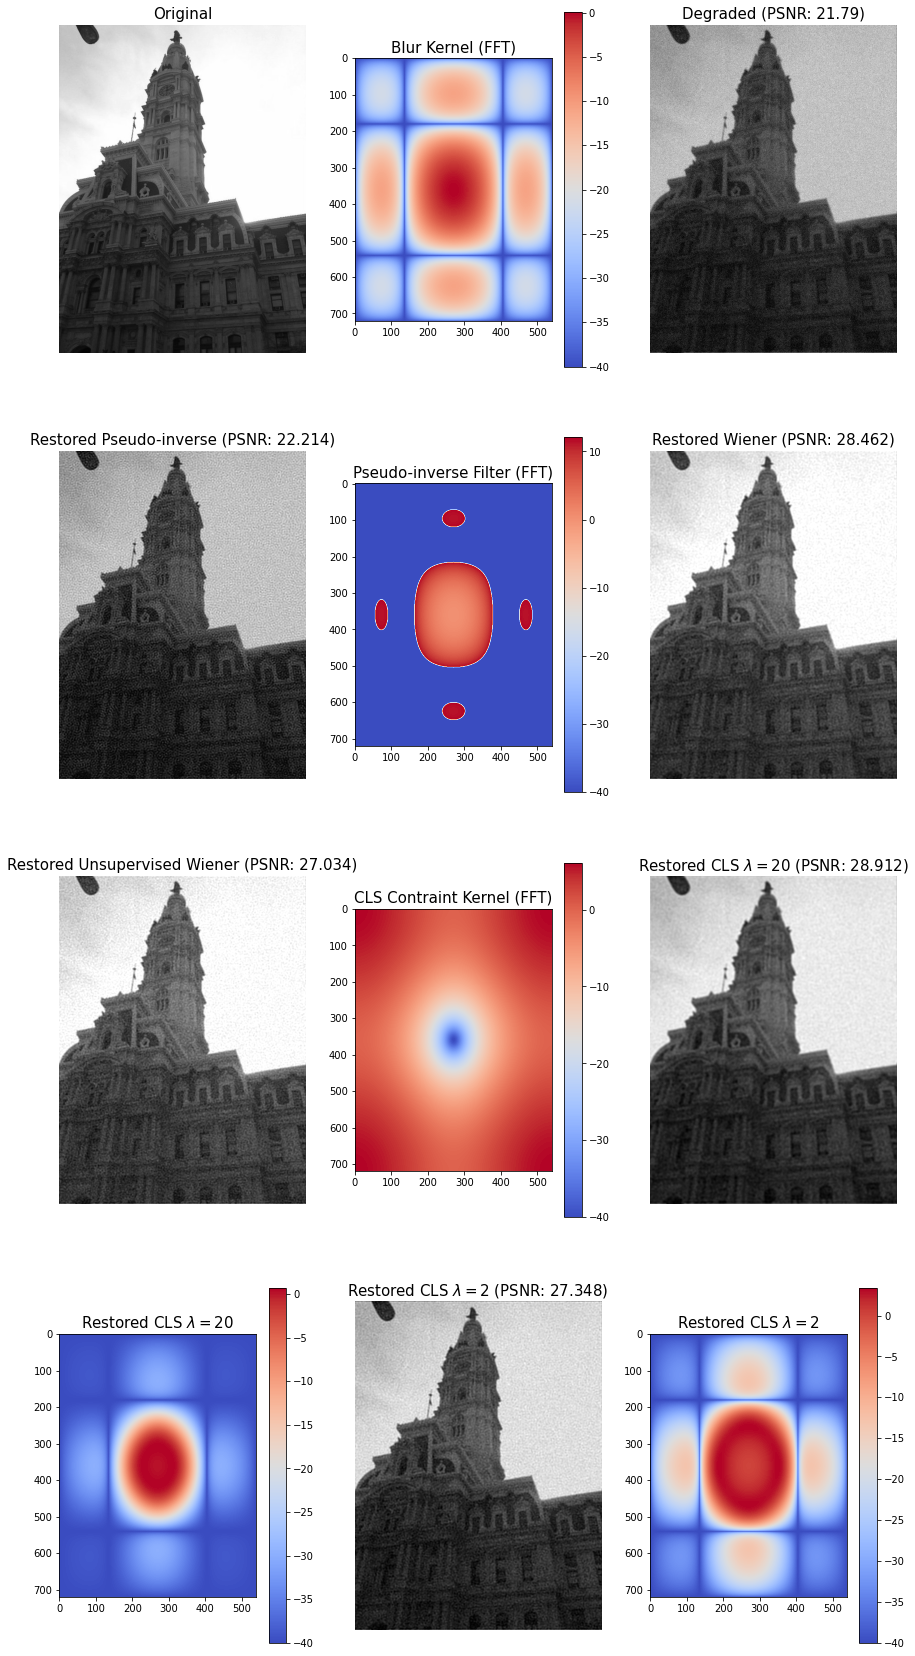

In [19]:
x = rgb2gray(imread('imagenes/building.png'))
print(x.shape)
M, N = x.shape
print(np.max(x))

plt.figure(figsize=(15, 30))

plt.subplot(431), plt.imshow(x, cmap='gray'), plt.axis('off'), plt.title('Original', size=15)

h = np.ones((4, 4)) / 16
h = np.pad(h, [(M//2 - 2, M//2 - 2), (N//2 - 2, N//2 - 2)], 'constant')
sigma = 0.075
Xf = fp.fft2(x)
Hf = fp.fft2(fp.ifftshift(h))

plt.subplot(432), plt.imshow(20*np.log10(0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'),
plt.title('Blur Kernel (FFT)', size=15), plt.colorbar()

Y = Hf * Xf
y = fp.ifft2(Y).real + sigma * np.random.randn(M, N)

plt.subplot(433), plt.imshow(np.abs(y), cmap='gray'), plt.axis('off'),
plt.title(f'Degraded (PSNR: {np.round(psnr(x, y), 3)})', size=15)

## restauración con pseudo inverse

epsilon = 0.25
pix, F_pseudo = pseudo_inverse_filter(y, h, epsilon)

plt.subplot(434), plt.imshow(pix, cmap='gray'), plt.axis('off'),
plt.title(f'Restored Pseudo-inverse (PSNR: {np.round(psnr(x, pix), 3)})', size=15)

plt.subplot(435), plot_freq_filter(F_pseudo, 'Pseudo-inverse Filter (FFT)', size=15)

# Restauración con wiener

wx = wiener(y, h, balance=0.25)
plt.subplot(436), plt.imshow(wx, cmap='gray'), plt.axis('off'),
plt.title(f'Restored Wiener (PSNR: {np.round(psnr(x, wx), 3)})', size=15)

# restoration unsipervised wiener 

uwx, _ = unsupervised_wiener(y, h)
plt.subplot(437), plt.imshow(uwx, cmap='gray'), plt.axis('off'),
plt.title(f'Restored Unsupervised Wiener (PSNR: {np.round(psnr(x, uwx), 3)})', size=15)

# Restauración con cls filter
c = np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2 - 1, M//2 - 2), (N//2 - 2, N//2 - 1)], 'constant')
Cf = fp.fft2(fp.ifftshift(c))

plt.subplot(438), plt.imshow(20*np.log10(0.01 + np.abs(fp.fftshift(Cf))), cmap='coolwarm'),
plt.title(f"CLS Contraint Kernel (FFT)", size=15), plt.colorbar()

lambd = 20
clx, F_restored = cls_filter(y, h, c, lambd)
plt.subplot(439), plt.imshow(clx, cmap='gray'), plt.axis('off'),
plt.title(f'Restored CLS $\lambda=${lambd} (PSNR: {np.round(psnr(x, clx), 3)})', size=15)
plt.subplot(4,3,10), plot_freq_filter(F_restored, f'Restored CLS $\lambda=${lambd}', size=15)

lambd = 2
clx, F_restored = cls_filter(y, h, c, lambd)
plt.subplot(4,3,11), plt.imshow(clx, cmap='gray'), plt.axis('off'),
plt.title(f'Restored CLS $\lambda=${lambd} (PSNR: {np.round(psnr(x, clx), 3)})', size=15)
plt.subplot(4,3,12), plot_freq_filter(F_restored, f'Restored CLS $\lambda=${lambd}', size=15)

In [20]:
def plot_freq_spec_3d(freq):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection='3d')
  Y = np.arange(-freq.shape[0]//2, freq.shape[0]-freq.shape[0]//2)
  X = np.arange(-freq.shape[1]//2, freq.shape[1]-freq.shape[1]//2)
  X, Y = np.meshgrid(X, Y)
  Z = (20*np.log10(0.01 + np.abs(freq))).real
  surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
  plt.show()

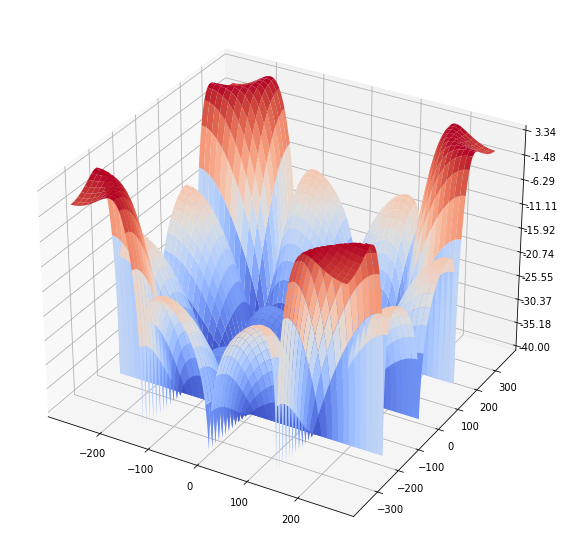

In [23]:
plot_freq_spec_3d(F_restored)

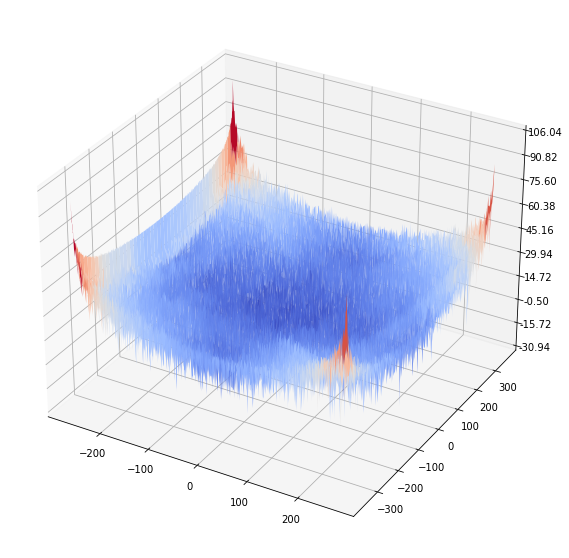

In [25]:
plot_freq_spec_3d(fp.fft2(x))

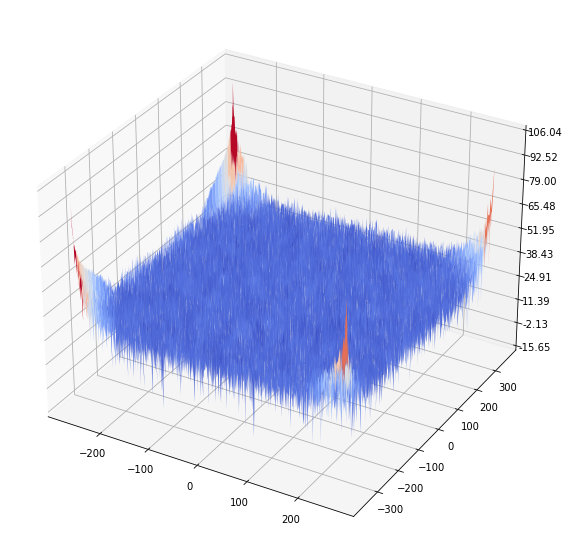

In [26]:
plot_freq_spec_3d(fp.fft2(y))

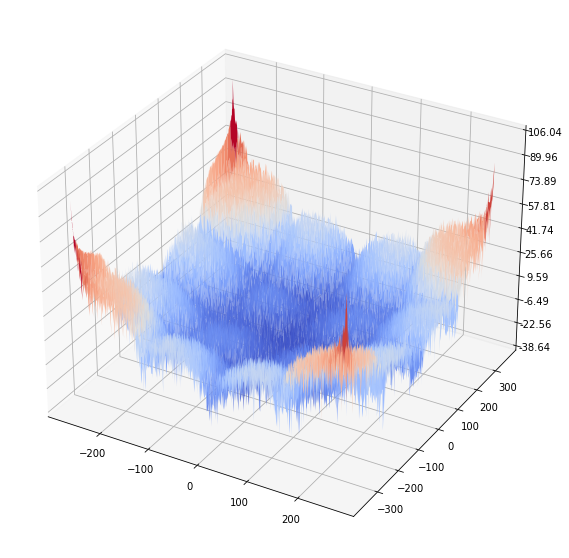

In [27]:
plot_freq_spec_3d(fp.fft2(clx))

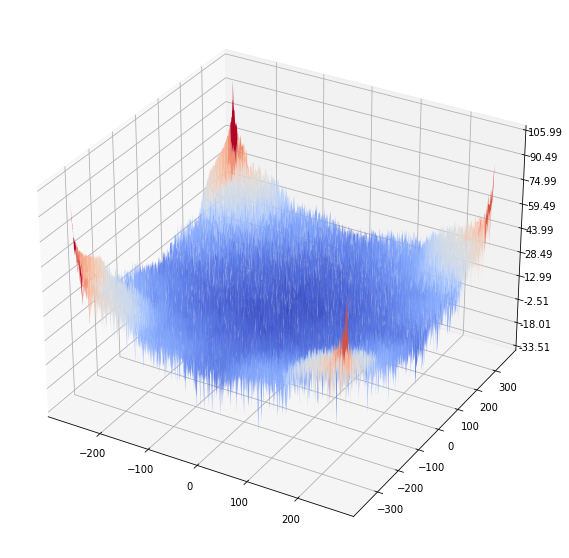

In [28]:
plot_freq_spec_3d(fp.fft2(uwx))

## Reconstructing motion blur

In [30]:
from skimage.util import random_noise

In [31]:
def convolve2d(im, psf, k):
  M, N = im.shape
  freq = fp.fft2(im)
  psf = np.pad(psf, (((M-k)//2, (M-k)//2+1), ((N-k)//2, (N-k)//2+1)), 'constant')
  freq_kernel = fp.fft2(fp.ifftshift(psf))
  return np.abs(fp.ifft2(freq * freq_kernel))

In [35]:
im = rgb2gray(rgba2rgb(imread('imagenes/bird.png')))
(M, N), k = im.shape, 81
kernel = np.zeros((k, k))
for i in range(k):
  kernel[i, i] = 1

kernel = kernel / k

print(im.shape, kernel.shape)
im_blur = convolve2d(im, kernel, k)
im_blur = random_noise(im_blur, var=0.0025)

(656, 592) (81, 81)


Text(0.5, 1.0, 'Restored image CLR $\\lambda=7.5$ PSNR=22.622')

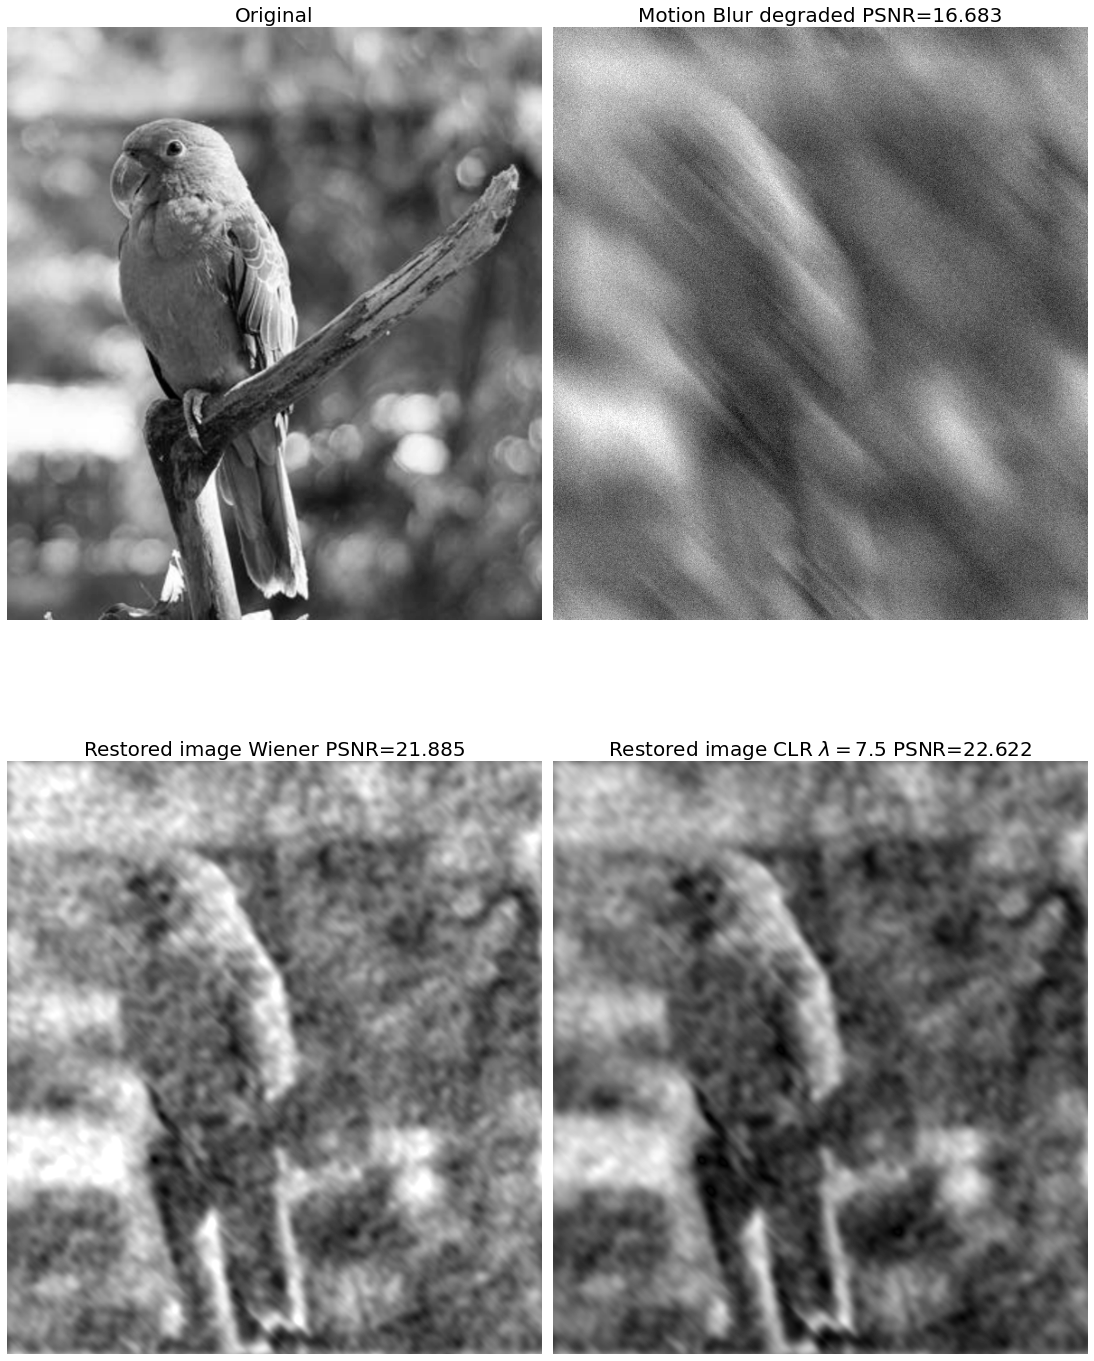

In [39]:
x = im
y = im_blur
h = kernel

h = np.pad(h, ((M//2 - k//2, M//2 - k//2 - 1), (N//2 - k//2, N//2 - k//2 - 1)), 'constant')

# restoration with wiener
wx = wiener(y, h, balance=0.25)

# restoration with cls filter

c = np.array([[0, 1/4, 0],[1/4, -1, 1/4],[0, 1/4, 0]])
c = np.pad(c, ((M//2 - 1, M//2 - 2), (N//2 - 2, N//2 - 1)), 'constant')
Cf = fp.fft2(fp.ifftshift(c))
lambd = 7.5
clx, F_restored = cls_filter(y, h, c, lambd)

plt.figure(figsize=(15,20))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.02,0.04)
plt.subplot(221), plt.imshow(x), plt.axis('off'), plt.title('Original', size=20)
plt.subplot(222), plt.imshow(y), plt.axis('off'),
plt.title(f'Motion Blur degraded PSNR={np.round(psnr(x, y), 3)}', size=20)

plt.subplot(223), plt.imshow(wx), plt.axis('off'),
plt.title(f'Restored image Wiener PSNR={np.round(psnr(x, wx), 3)}', size=20)
plt.subplot(224), plt.imshow(clx), plt.axis('off'),
plt.title(f'Restored image CLR $\lambda={lambd}$ PSNR={np.round(psnr(x, clx), 3)}', size=20)